In [1]:
## Get dependencies ##

import numpy as np
import string
import math
import sys
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sn
from UnFaIR import *
import scipy as sp
import pickle

In [7]:
RCPs = ['3PD','45','6','85']
RCP_ems = {}
RCP_C = {}
otherforc = {}
total_forc = {}

# We should really fit the thermal response first (using total forcing), then the gas cycles

for s in RCPs:
    RCP_E = pd.read_csv('./RCP_data/RCP'+s+'_EMISSIONS.csv',skiprows=36,index_col=0)
    RCP_ems[s] = pd.DataFrame(data = np.array([RCP_E[['OtherCO2','FossilCO2']].sum(axis=1).values,RCP_E['CH4'].values,RCP_E['N2O'].values]).T,columns=['CO2','CH4','N2O'],index = RCP_E.index)
    RCP_C[s] = pd.read_csv('./RCP_data/RCP'+s+'_MIDYEAR_CONCENTRATIONS.csv',skiprows=37,index_col=0)
    RCP_forc = pd.read_csv('./Conc_fit_data/RCP'+s+'_MIDYEAR_RADFORCING.csv',skiprows=58,index_col=0)
    otherforc[s] = RCP_forc.TOTAL_INCLVOLCANIC_RF.values - RCP_forc.CO2CH4N2O_RF.values
    total_forc[s] = RCP_forc.TOTAL_INCLVOLCANIC_RF.values

## import CMIP5 model mean temp response:

CMIP5_temps = {}

CMIP5_temps['3PD'] = pd.read_csv('./Conc_fit_data/CMIP5_model_mean_temp/icmip5_tas_Amon_modmean_rcp26_0-360E_-90-90N_n_000_mean1_anom_30.dat.txt',skiprows=29,delim_whitespace=True,names = ['Year','tas'], index_col=0)
CMIP5_temps['45'] = pd.read_csv('./Conc_fit_data/CMIP5_model_mean_temp/icmip5_tas_Amon_modmean_rcp45_0-360E_-90-90N_n_000_mean1_anom_30.dat.txt',skiprows=30,delim_whitespace=True,names = ['Year','tas'], index_col=0)
CMIP5_temps['6'] = pd.read_csv('./Conc_fit_data/CMIP5_model_mean_temp/icmip5_tas_Amon_modmean_rcp60_0-360E_-90-90N_n_000_mean1_anom_30.dat.txt',skiprows=29,delim_whitespace=True,names = ['Year','tas'], index_col=0)
CMIP5_temps['85'] = pd.read_csv('./Conc_fit_data/CMIP5_model_mean_temp/icmip5_tas_Amon_modmean_rcp85_0-360E_-90-90N_n_000_mean1_anom_30.dat.txt',skiprows=30,delim_whitespace=True,names = ['Year','tas'], index_col=0)

In [16]:
## Create an empty emissions set to match the forcing runs:

no_emissions = empty_emissions(1765,2500)

thermal_params = default_thermal_params()

def fit_thermal_params(x):
    
    fit_params = thermal_params.copy()
    fit_params.loc['d'] = [x[0],x[1]]
    fit_params.loc['q'] = np.array([x[2],x[3]])
    
    diff=0
    
    for s in RCPs:
                
        model_run = UnFaIR(no_emissions,total_forc[s],thermal_params = fit_params)
        
        model_T_baselined = model_run['T']['Total'].loc[CMIP5_temps[s].index] - model_run['T']['Total'].loc[1861:1880].mean()
        
        CMIP5_T_baselined = CMIP5_temps[s] - CMIP5_temps[s].loc[1861:1880].mean()
        
        diff += np.sum((model_T_baselined.values.flatten() - CMIP5_T_baselined.values.flatten())**2)/np.sum(CMIP5_T_baselined.values.flatten()**2)
        
    return diff

thermal_params_fit = sp.optimize.minimize(fit_thermal_params,np.array([240,4,1.5,3]),method='Nelder-Mead')

           1         2
d  71.507508  3.284680
q   0.312707  0.425155


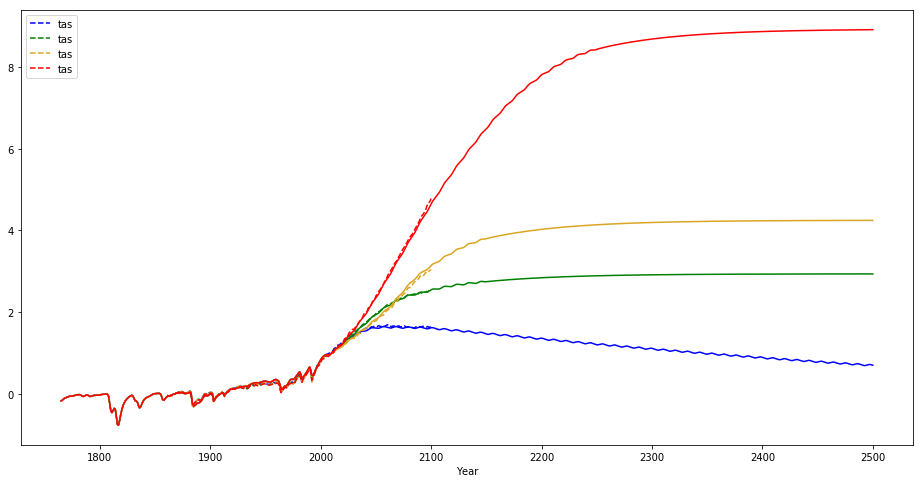

In [17]:
## Show the fit:

x = thermal_params_fit['x']
thermal_params.loc['d'] = [x[0],x[1]]
thermal_params.loc['q'] = np.array([x[2],x[3]])

print(thermal_params)

colors=['b','green','goldenrod','r']

fig,ax = plt.subplots(figsize=(16,8))

for i,s in enumerate(RCPs):
    model_run = UnFaIR(no_emissions,total_forc[s],thermal_params=thermal_params)
    (model_run['T']['Total'] - model_run['T']['Total'].loc[1861:1880].mean()).plot(ax=ax,color=colors[i],label = s)
    (CMIP5_temps[s]-CMIP5_temps[s].loc[1861:1880].mean()).plot(ax=ax,linestyle='--',color=colors[i])
    

In [19]:
## Next we fit the forcing repsonse

RCP_forc_runs = {}

gas_params = default_gas_params()

for s in RCPs:
    RCP_forc = pd.read_csv('./Conc_fit_data/RCP'+s+'_MIDYEAR_RADFORCING.csv',skiprows=58,index_col=0)
    RCP_forc_runs[s] = pd.DataFrame(data=RCP_forc[['CO2_RF','CH4_RF','N2O_RF']].values,index = RCP_forc.index,columns = ['CO2','CH4','N2O'])
    
forcing_params = default_forcing_params()
    
def fit_rcp_forc(x,species):
    
    diff = 0
    
    for s in RCPs:
    
        model_run = step_forc(C = RCP_C[s][species].values,PI_conc = gas_params.loc['PI_conc',species], f = np.array([x[0],x[1],x[2]]))
    
        diff += np.sum((model_run.flatten() - RCP_forc_runs[s][species].values.flatten())**2)
        
    return diff
    
CO2_forc_param_fit = sp.optimize.minimize(fit_rcp_forc,default_forcing_params()['CO2'].values,args=('CO2'),method='Nelder-Mead')
CH4_forc_param_fit = sp.optimize.minimize(fit_rcp_forc,default_forcing_params()['CH4'].values,args=('CH4'),method='Nelder-Mead')
N2O_forc_param_fit = sp.optimize.minimize(fit_rcp_forc,default_forcing_params()['N2O'].values,args=('N2O'),method='Nelder-Mead')

         CO2       CH4       N2O
f1  5.398781  0.000583  0.000149
f2 -0.000046  0.000005 -0.000201
f3  0.000140  0.030661  0.121083


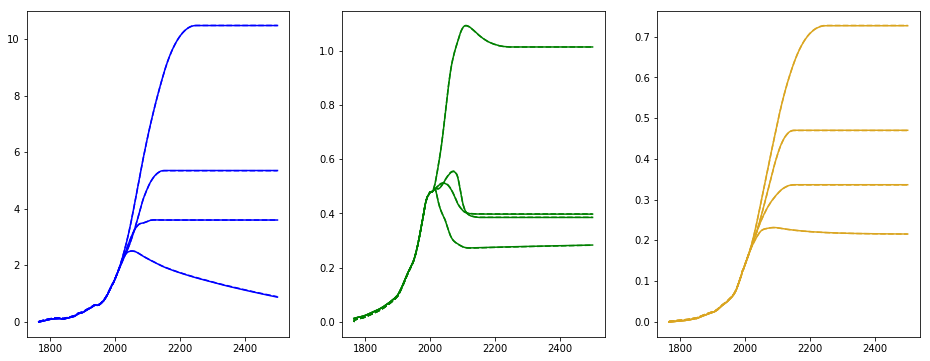

In [20]:
x = CO2_forc_param_fit['x']
forcing_params['CO2'] = np.array([x[0],x[1],x[2]])
x = CH4_forc_param_fit['x']
forcing_params['CH4'] = np.array([x[0],x[1],x[2]])
x = N2O_forc_param_fit['x']
forcing_params['N2O'] = np.array([x[0],x[1],x[2]])

print(forcing_params)

fig,ax=plt.subplots(1,3,figsize=(16,6))

for s in RCPs:
    for i,species in enumerate(['CO2','CH4','N2O']):
        model_run = step_forc(C = RCP_C[s][species].values,PI_conc = gas_params.loc['PI_conc',species], f = forcing_params[species].values)
        ax[i].plot(RCP_forc_runs[s].index,model_run,color=colors[i])
        ax[i].plot(RCP_forc_runs[s][species],color=colors[i],linestyle='--')

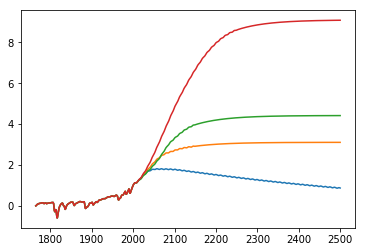

In [21]:
## Finally we fit the gas cycle with an input temp response (to prevent excessive endogenous variables)

RCP_T_response = {}

for s in RCPs:
    RCP_forc = pd.read_csv('./Conc_fit_data/RCP'+s+'_MIDYEAR_RADFORCING.csv',skiprows=58,index_col=0)
    total_forc[s] = RCP_forc.TOTAL_INCLVOLCANIC_RF.values

for s in RCPs:
    
    RCP_T_response[s] = UnFaIR(no_emissions,total_forc[s],forcing_params=forcing_params,thermal_params=thermal_params)['T']['Total']
    plt.plot(RCP_T_response[s])
    

In [22]:
gas_params = default_gas_params()

def fit_rcp_gas_cycles(x,species):
    
    fit_params = gas_params.copy()
    
    diff = 0
    
    if species == 'CO2':
        fit_params.loc[['r0','rC','rT'],species] = np.array([x[0],x[1],x[2]])
    if species == 'CH4':
        fit_params.loc[['r0','rT','rA','PI_conc'],species] = np.array([x[0],x[1],x[2],x[3]])
    if species == 'N2O':
        fit_params.loc[['r0','rA','PI_conc'],species] = np.array([x[0],x[1],x[2]])
        
    for s in RCPs:
        
        model_run = fit_gas_cycles(RCP_ems[s],RCP_T_response[s],fit_params)
        
        diff += np.sum((model_run[species].loc[2005:].values.flatten() - RCP_C[s][species].loc[2005:].values.flatten())**2)/np.sum((RCP_C[s][species].loc[2005:].values.flatten())**2)
        
    return diff
    
CO2_rcp_params_fit = sp.optimize.minimize(fit_rcp_gas_cycles,[30,0.02,4],args=('CO2'),method='Nelder-Mead')
print('CO2 done',CO2_rcp_params_fit['message'])
CH4_rcp_params_fit = sp.optimize.minimize(fit_rcp_gas_cycles,[9,-0.3,0.0003,700.],args=('CH4'),method='Nelder-Mead')
print('CH4 done',CH4_rcp_params_fit['message'])
bnds=((50,100),(-1,0))
N2O_rcp_params_fit = sp.optimize.minimize(fit_rcp_gas_cycles,[70,-0.0009,273.],args=('N2O'),method='Powell')#,bounds=bnds)
print('N2O done',N2O_rcp_params_fit['message'])

CO2 done Optimization terminated successfully.
CH4 done Optimization terminated successfully.
N2O done Optimization terminated successfully.


                      CO2         CH4         N2O
a1               0.217300    1.000000    1.000000
a2               0.224000    0.000000    0.000000
a3               0.282400    0.000000    0.000000
a4               0.276300    0.000000    0.000000
tau1       1000000.000000    9.150000  116.000000
tau2           394.400000    1.000000    1.000000
tau3            36.540000    1.000000    1.000000
tau4             4.304000    1.000000    1.000000
r0              35.208543    7.762268   57.082676
rC               0.007471    0.000000    0.000000
rT               5.209584   -0.206751    0.000000
rA               0.000000    0.000323    0.005242
PI_conc        278.000000  873.737531  255.210095
emis2conc        0.468952    0.351714    0.200980 
 
          CO2       CH4       N2O
f1  5.398781  0.000583  0.000149
f2 -0.000046  0.000005 -0.000201
f3  0.000140  0.030661  0.121083 
 
            1         2
d  71.507508  3.284680
q   0.312707  0.425155


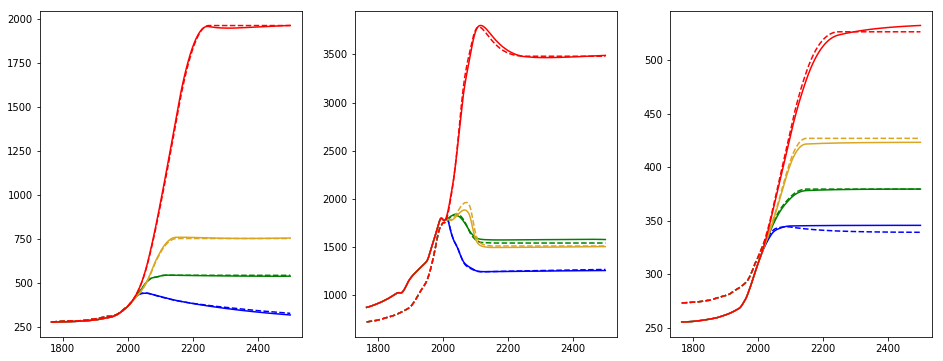

In [32]:
x = CO2_rcp_params_fit['x']
gas_params.loc['r0':'rT','CO2'] = np.array([x[0],x[1],x[2]])
x = CH4_rcp_params_fit['x']
gas_params.loc[['r0','rT','rA','PI_conc'],'CH4'] = np.array([x[0],x[1],x[2],x[3]])
x = N2O_rcp_params_fit['x']
gas_params.loc[['r0','rA','PI_conc'],'N2O'] = np.array([x[0],x[1],x[2]])

fig,ax=plt.subplots(1,3,figsize=(16,6))

model_run = {}

for ii,s in enumerate(RCPs):
    model_run[s] = UnFaIR(RCP_ems[s],otherforc[s],gas_params=gas_params,thermal_params=thermal_params,forcing_params=forcing_params)
    for i,species in enumerate(['CO2','CH4','N2O']):
        ax[i].plot(model_run[s]['C'][species],color=colors[ii])
        ax[i].plot(RCP_C[s][species],color=colors[ii],linestyle='--')

print(model_run[s]['gas_params'],'\n','\n',model_run[s]['forcing_params'],'\n','\n',model_run[s]['thermal_params'])

#param_dict = {'gas_params':model_run[s]['gas_params'], 'thermal_params': model_run[s]['thermal_params'], 'forcing_params': model_run[s]['forcing_params']}

#pickle.dump(param_dict,open('MAGICC_RCP_optimal_parameters.p', 'wb'))

(-0.4, 5.5)

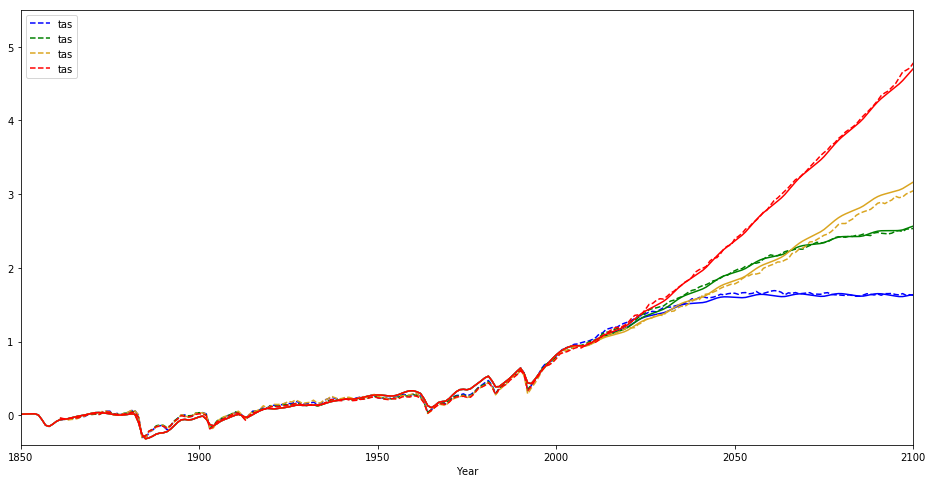

In [24]:
## How well does a full emission -> temperatures run match cmip5 model mean?

fig,ax = plt.subplots(figsize=(16,8))

for i,s in enumerate(RCPs):
    (model_run[s]['T']['Total'] - model_run[s]['T']['Total'].loc[1861:1880].mean()).plot(ax=ax,color=colors[i],label = s)
    (CMIP5_temps[s]-CMIP5_temps[s].loc[1861:1880].mean()).plot(ax=ax,linestyle='--',color=colors[i])

ax.set_xlim(1850,2100)
ax.set_ylim(-0.4,5.5)

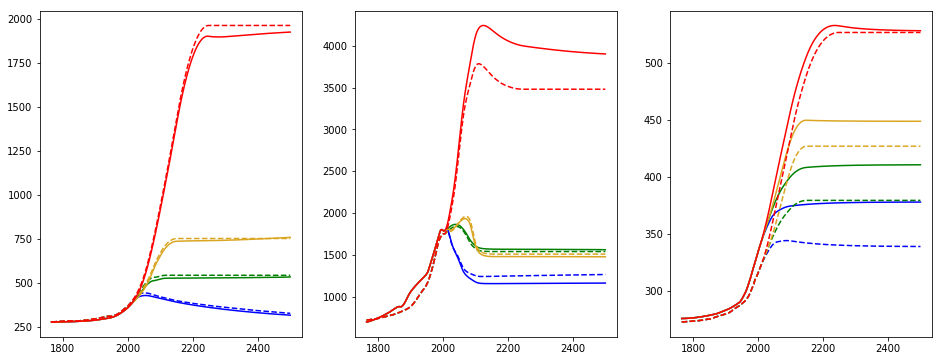

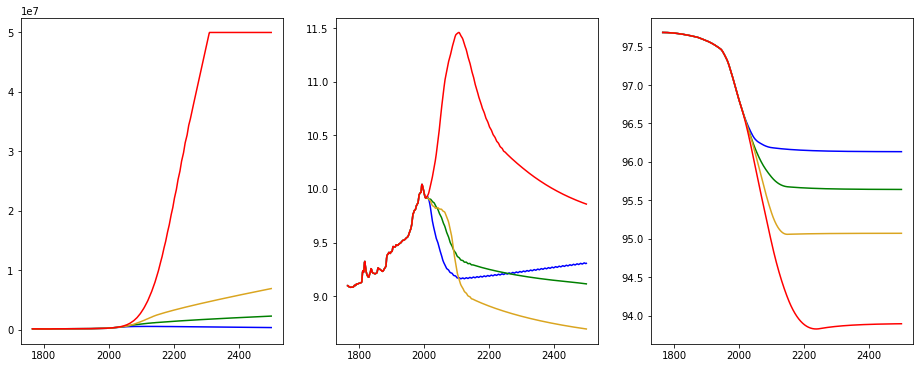

In [35]:
## Testing RCP data with "best fit" parameters:

best_params = pd.read_pickle('Best_fit_optimal_parameters.p')

best_params.loc['r0':'rT','CO2'] = [29.5,0.018,0.018*4.165/0.019]

fig,ax=plt.subplots(1,3,figsize=(16,6))

fig1,ax1 = plt.subplots(1,3,figsize=(16,6))

model_run = {}

for ii,s in enumerate(RCPs):
    model_run[s] = UnFaIR(RCP_ems[s],otherforc[s],gas_params=best_params)
    for i,species in enumerate(['CO2','CH4','N2O']):
        ax[i].plot(model_run[s]['C'][species],color=colors[ii])
        ax[i].plot(RCP_C[s][species],color=colors[ii],linestyle='--')
        
        ax1[i].plot(model_run[s]['alpha'][species]*gas_params.loc['tau1',species],color=colors[ii])
        
        